In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

In [2]:
run ../util/setupConsole_su

In [3]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'

In [4]:
era5_max_quantiles = xr.open_dataset('%s/era5_tw_max_quantiles.nc'%dirHeatData)
lat = era5_max_quantiles.latitude.values
lon = era5_max_quantiles.longitude.values

In [5]:
# for y, year in enumerate(range(1981, 2019+1)):
#     os.rename('heat_wave_days/era5_cold_wave_days_%d.dat'%year, 'heat_wave_days/era5_t_min_wave_days_%d.dat'%year)

In [96]:
yearRange = np.arange(1981, 1990+1)

In [97]:
lat_inds = np.where((lat < 45) & (lat >= 30))[0]
lon_inds = np.where((lon < 40) & (lon >= 20))[0]

In [98]:
dayoffset_tw = {}
dayoffset_tx_during_tw = {}
dayoffset_tx = {}
dayoffset_tw_during_tx = {}

q = 0
l = 7

for year in yearRange:
    print('loading %d'%year)
    with open('%s/heat-wave-days/hw-dayoffset/dayoffset_tx_global_%d_%d_%d'%(dirHeatData, l, q, year), 'rb') as f:
        dayoffset_tx[year] = pickle.load(f)
    with open('%s/heat-wave-days/hw-dayoffset/dayoffset_tw_during_tx_global_%d_%d_%d'%(dirHeatData, l, q, year), 'rb') as f:
        dayoffset_tw_during_tx[year] = pickle.load(f)
    with open('%s/heat-wave-days/hw-dayoffset/dayoffset_tw_global_%d_%d_%d'%(dirHeatData, l, q, year), 'rb') as f:
        dayoffset_tw[year] = pickle.load(f)
    with open('%s/heat-wave-days/hw-dayoffset/dayoffset_tx_during_tw_global_%d_%d_%d'%(dirHeatData, l, q, year), 'rb') as f:
        dayoffset_tx_during_tw[year] = pickle.load(f)

# dayoffset_tx = np.array(dayoffset_tx)
# dayoffset_tw_during_tx = np.array(dayoffset_tw_during_tx)

# dayoffset_tw = np.array(dayoffset_tw)
# dayoffset_tx_during_tw = np.array(dayoffset_tx_during_tw)

loading 1981
loading 1982
loading 1983
loading 1984
loading 1985
loading 1986
loading 1987
loading 1988
loading 1989
loading 1990


In [114]:
hw_max_tx = np.full([len(yearRange), lat.size, lon.size], np.nan)
hw_max_tw_during_tx = np.full([len(yearRange), lat.size, lon.size], np.nan)

hw_max_tw = np.full([len(yearRange), lat.size, lon.size], np.nan)
hw_max_tx_during_tw = np.full([len(yearRange), lat.size, lon.size], np.nan)

for y,year in enumerate(yearRange):
    for xlat in range(lat.size):
        for ylon in range(lon.size):
            if dayoffset_tx[year][xlat][ylon].size > 0:
                hw_max_tx[y, xlat, ylon] = np.nanmean(np.nanmean(dayoffset_tx[year][xlat][ylon], axis=1))
                
            if dayoffset_tw_during_tx[year][xlat][ylon].size > 0:
                hw_max_tw_during_tx[y, xlat, ylon] = np.nanmean(np.nanmean(dayoffset_tw_during_tx[year][xlat][ylon], axis=1))
                
            if dayoffset_tw[year][xlat][ylon].size > 0:
                hw_max_tw[y, xlat, ylon] = np.nanmean(np.nanmean(dayoffset_tw[year][xlat][ylon], axis=1))
                
            if dayoffset_tx_during_tw[year][xlat][ylon].size > 0:
                hw_max_tx_during_tw[y, xlat, ylon] = np.nanmean(np.nanmean(dayoffset_tx_during_tw[year][xlat][ylon], axis=1))
# regional_dayoffset_tx = np.squeeze(np.array(regional_dayoffset_tx))

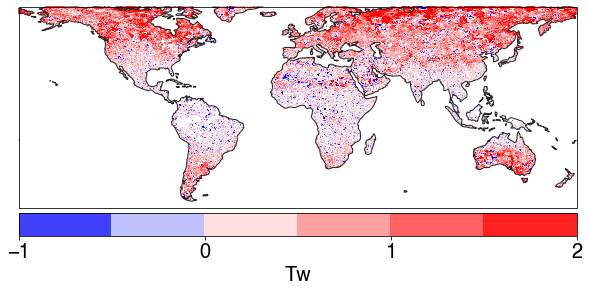

In [123]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -1
v2 = 2.01
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = np.nanmean(hw_max_tw, axis=0)

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tw', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

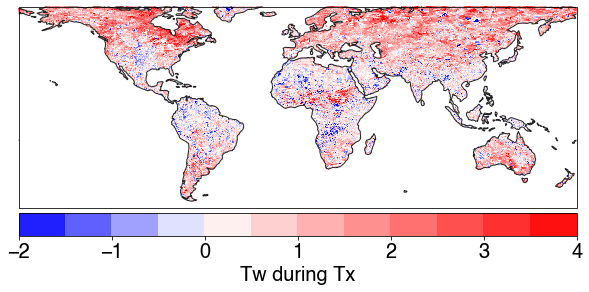

In [119]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -2
v2 = 4.01
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = np.nanmean(hw_max_tw_during_tx, axis=0)

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tw during Tx', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

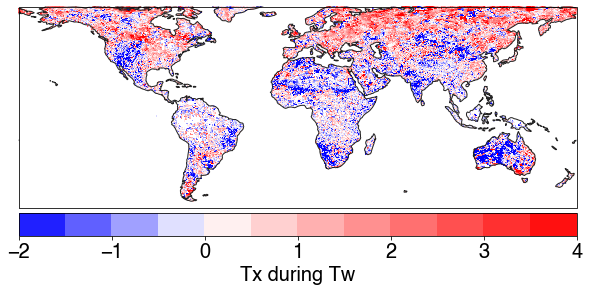

In [120]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -2
v2 = 4.01
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = np.nanmean(hw_max_tx_during_tw, axis=0)

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tx during Tw', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [55]:
grid = np.full([lat.size, lon.size], 0)
for xlat in range(lat.size):
    for ylon in range(lon.size):
        if len(dayoffset_tx[1982][xlat][ylon]) > 0:
            grid[xlat,ylon] = len(dayoffset_tx[1982][xlat][ylon])

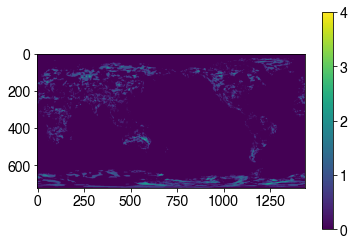

In [56]:
plt.imshow(grid);plt.colorbar()

In [136]:
dayoffset_tw = []
dayoffset_tx_during_tw = []
dayoffset_tx = []
dayoffset_tw_during_tx = []

region = 'tropics'
q = 0
l = 7

for year in yearRange:
    with open('%s/heat-wave-days/hw-dayoffset/dayoffset_tx_%s_%d_%d_%d'%(dirHeatData, region, l, q, year), 'rb') as f:
        dayoffset_tx.append(pickle.load(f))
    with open('%s/heat-wave-days/hw-dayoffset/dayoffset_tw_during_tx_%s_%d_%d_%d'%(dirHeatData, region, l, q, year), 'rb') as f:
        dayoffset_tw_during_tx.append(pickle.load(f))
    with open('%s/heat-wave-days/hw-dayoffset/dayoffset_tw_%s_%d_%d_%d'%(dirHeatData, region, l, q, year), 'rb') as f:
        dayoffset_tw.append(pickle.load(f))
    with open('%s/heat-wave-days/hw-dayoffset/dayoffset_tx_during_tw_%s_%d_%d_%d'%(dirHeatData, region, l, q, year), 'rb') as f:
        dayoffset_tx_during_tw.append(pickle.load(f))

dayoffset_tx = np.array(dayoffset_tx)
dayoffset_tw_during_tx = np.array(dayoffset_tw_during_tx)

dayoffset_tw = np.array(dayoffset_tw)
dayoffset_tx_during_tw = np.array(dayoffset_tx_during_tw)

In [141]:
f1 = []
f2 = []

max_tx_during_tx = []
max_tw_during_tx = []
max_tw_during_tw = []
max_tx_during_tw = []

for y, year in enumerate(yearRange):
    ind_tx_during_tw_neg = np.where(np.nanmean(dayoffset_tx_during_tw[y][:,1:], axis=1)<0)[0]
    ind_tx_during_tw_pos = np.where(np.nanmean(dayoffset_tx_during_tw[y][:,1:], axis=1)>0)[0]

    ind_tw_during_tx_neg = np.where(np.nanmean(dayoffset_tw_during_tx[y][:,1:], axis=1)<0)[0]
    ind_tw_during_tx_pos = np.where(np.nanmean(dayoffset_tw_during_tx[y][:,1:], axis=1)>0)[0]
    
    max_tx_during_tx.append(np.nanmean(np.nanmax(dayoffset_tx[y][:, :], axis=1)))
    max_tw_during_tx.append(np.nanmean(np.nanmax(dayoffset_tw_during_tx[y][:, :], axis=1)))
    max_tw_during_tw.append(np.nanmean(np.nanmax(dayoffset_tw[y][:, :], axis=1)))
    max_tx_during_tw.append(np.nanmean(np.nanmax(dayoffset_tx_during_tw[y][:, :], axis=1)))
    
    f1.append(ind_tx_during_tw_pos.size/(ind_tx_during_tw_neg.size+ind_tx_during_tw_pos.size))
    f2.append(ind_tw_during_tx_pos.size/(ind_tw_during_tx_neg.size+ind_tw_during_tx_pos.size))

f1 = np.array(f1)
f2 = np.array(f2)

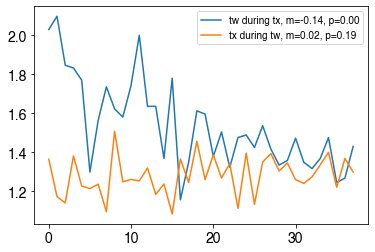

In [142]:
X = sm.add_constant(yearRange)
mdl1 = sm.OLS(max_tx_during_tw,X).fit()

X = sm.add_constant(yearRange)
mdl2 = sm.OLS(max_tw_during_tx,X).fit()


plt.plot(max_tw_during_tx, label='tw during tx, m=%.2f, p=%.2f'%(mdl2.params[1]*10, mdl2.pvalues[1]))
plt.plot(max_tx_during_tw, label='tx during tw, m=%.2f, p=%.2f'%(mdl1.params[1]*10, mdl1.pvalues[1]))
plt.legend()

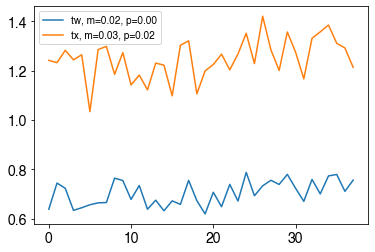

In [143]:
X = sm.add_constant(yearRange)
mdl1 = sm.OLS(max_tx_during_tx,X).fit()

X = sm.add_constant(yearRange)
mdl2 = sm.OLS(max_tw_during_tw,X).fit()

plt.plot(max_tw_during_tw, label='tw, m=%.2f, p=%.2f'%(mdl2.params[1]*10, mdl2.pvalues[1]))
plt.plot(max_tx_during_tx, label='tx, m=%.2f, p=%.2f'%(mdl1.params[1]*10, mdl1.pvalues[1]))
plt.legend()

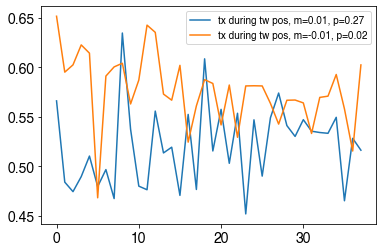

In [144]:
X = sm.add_constant(yearRange)
mdl1 = sm.OLS(f1,X).fit()

X = sm.add_constant(yearRange)
mdl2 = sm.OLS(f2,X).fit()

plt.plot(f1, label='tx during tw pos, m=%.2f, p=%.2f'%(mdl1.params[1]*10, mdl1.pvalues[1]))
plt.plot(f2, label='tx during tw pos, m=%.2f, p=%.2f'%(mdl2.params[1]*10, mdl2.pvalues[1]))
plt.legend()

In [145]:
plt.plot(np.nanmedian(dayoffset_tw[ind_tx_during_tw_pos,:], axis=0), label='tw, n=%.2f'%(ind_tx_during_tw_pos.size/dayoffset_tw.shape[0]))
plt.plot(np.nanmedian(dayoffset_tx_during_tw[ind_tx_during_tw_pos,:], axis=0), label='tx during tw')
plt.legend()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

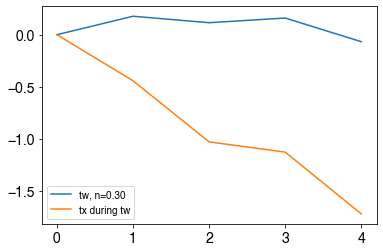

In [14]:
plt.plot(np.nanmedian(dayoffset_tw[ind_tx_during_tw_neg,:], axis=0), label='tw, n=%.2f'%(ind_tx_during_tw_neg.size/dayoffset_tw.shape[0]))
plt.plot(np.nanmedian(dayoffset_tx_during_tw[ind_tx_during_tw_neg,:], axis=0), label='tx during tw')
plt.legend()

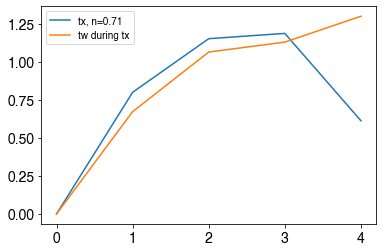

In [15]:
plt.plot(np.nanmedian(dayoffset_tx[ind_tw_during_tx_pos,:], axis=0), label='tx, n=%.2f'%(ind_tw_during_tx_pos.size/dayoffset_tx.shape[0]))
plt.plot(np.nanmedian(dayoffset_tw_during_tx[ind_tw_during_tx_pos,:], axis=0), label='tw during tx')
plt.legend()

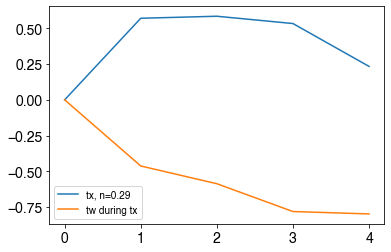

In [16]:
plt.plot(np.nanmedian(dayoffset_tx[ind_tw_during_tx_neg,:], axis=0), label='tx, n=%.2f'%(ind_tw_during_tx_neg.size/dayoffset_tx.shape[0]))
plt.plot(np.nanmedian(dayoffset_tw_during_tx[ind_tw_during_tx_neg,:], axis=0), label='tw during tx')
plt.legend()

In [17]:
np.nanmean(lens_tw)

5.0

In [39]:
%%time
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

if not os.path.isfile('%s/heat-wave-days/full-year/trends/wave_days_t_max_trends.dat'%dirHeatData):
    wave_days_t_max_trends = xr.apply_ufunc(new_linregress, wave_days_t_max_xr.time, wave_days_t_max_xr.t_max,
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[["p"]],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float64'],
                           output_sizes={"p": 5},
                          )
    with open('%s/heat-wave-days/full-year/trends/wave_days_t_max_trends.dat'%dirHeatData, 'wb') as f:
        pickle.dump(wave_days_t_max_trends, f)
else:
    with open('%s/heat-wave-days/full-year/trends/wave_days_t_max_trends.dat'%dirHeatData, 'rb') as f:
        wave_days_t_max_trends = pickle.load(f)

NameError: name 'wave_days_t_max_xr' is not defined

In [25]:
%%time
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

if not os.path.isfile('%s/heat-wave-days/full-year/trends/wave_days_tw_max_trends.dat'%dirHeatData):
    wave_days_tw_max_trends = xr.apply_ufunc(new_linregress, wave_days_tw_max_xr.time, wave_days_tw_max_xr.tw_max,
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[["p"]],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float64'],
                           output_sizes={"p": 5},
                          )
    with open('%s/heat-wave-days/full-year/trends/wave_days_tw_max_trends.dat'%dirHeatData, 'wb') as f:
        pickle.dump(wave_days_tw_max_trends, f)
else:
    with open('%s/heat-wave-days/full-year/trends/wave_days_tw_max_trends.dat'%dirHeatData, 'rb') as f:
        wave_days_tw_max_trends = pickle.load(f)

CPU times: user 9min 14s, sys: 6.41 s, total: 9min 20s
Wall time: 9min 58s


In [37]:
wave_days_t_max_trends *= 10
# wave_days_t_min_trends *= 10
wave_days_tw_max_trends *= 10
# wave_days_tw_min_trends *= 10

In [39]:
%%time

sig_trends_only = False
sig_level = 0.1

kdd_trends_zonal_anom = kdd_trends - np.matlib.repmat(np.nanmean(kdd_trends, axis=1), 1, 1).T
gdd_trends_zonal_anom = gdd_trends - np.matlib.repmat(np.nanmean(gdd_trends, axis=1), 1, 1).T

trends_wave_days_t_max_zonal_anom = np.full([wave_days_t_max_trends.shape[0], wave_days_t_max_trends.shape[1], wave_days_t_max_trends.shape[2]], np.nan)
trends_wave_days_tw_max_zonal_anom = np.full([wave_days_tw_max_trends.shape[0], wave_days_tw_max_trends.shape[1], wave_days_tw_max_trends.shape[2]], np.nan)

# trends_wave_days_t_min_zonal_anom = np.full([wave_days_t_min_trends.shape[0], wave_days_t_min_trends.shape[1], wave_days_t_min_trends.shape[2]], np.nan)
# trends_wave_days_tw_min_zonal_anom = np.full([wave_days_tw_min_trends.shape[0], wave_days_tw_min_trends.shape[1], wave_days_tw_min_trends.shape[2]], np.nan)

for q in range(wave_days_t_max_trends.shape[2]):
    trends_wave_days_t_max_zonal_anom[:,:,q] = wave_days_t_max_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_t_max_trends[:,:,q,0], axis=1), 1, 1).T
    trends_wave_days_tw_max_zonal_anom[:,:,q] = wave_days_tw_max_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_tw_max_trends[:,:,q,0], axis=1), 1, 1).T
    
#     trends_wave_days_t_min_zonal_anom[:,:,q] = wave_days_t_min_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_t_min_trends[:,:,q,0], axis=1), 1, 1).T
#     trends_wave_days_tw_min_zonal_anom[:,:,q] = wave_days_tw_min_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_tw_min_trends[:,:,q,0], axis=1), 1, 1).T
    
    if sig_trends_only:
        trends_wave_days_t_max_zonal_anom[wave_days_t_max_trends[:,:,q,3] > sig_level, q] = np.nan
        trends_wave_days_tw_max_zonal_anom[wave_days_tw_max_trends[:,:,q,3] > sig_level, q] = np.nan
        
#         trends_wave_days_t_min_zonal_anom[wave_days_t_min_trends[:,:,q,3] > sig_level, q] = np.nan
#         trends_wave_days_tw_min_zonal_anom[wave_days_tw_min_trends[:,:,q,3] > sig_level, q] = np.nan
    

CPU times: user 1.01 s, sys: 20.1 ms, total: 1.03 s
Wall time: 1.03 s


In [40]:
usLat = [150,300]
usLon = [940,1150]
euroLat = [100,200]
euroLon = [0,200]

chinaLat = [150,300]
chinaLon = [350,500]

allLat = [0,-1]
allLon = [0,-1]

selLat = allLat
selLon = allLon

trends_wave_days_t_max_zonal_anom = trends_wave_days_t_max_zonal_anom[selLat[0]:selLat[1],selLon[0]:selLon[1],:]
trends_wave_days_tw_max_zonal_anom = trends_wave_days_tw_max_zonal_anom[selLat[0]:selLat[1],selLon[0]:selLon[1],:]
crop_ha_regrid = crop_ha_regrid[selLat[0]:selLat[1],selLon[0]:selLon[1]]

NameError: name 'crop_ha_regrid' is not defined

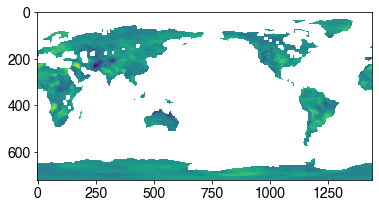

In [41]:
plt.imshow(trends_wave_days_tw_max_zonal_anom[:,:,5])

In [98]:
crop_ha_regrid_1d = np.reshape(crop_ha_regrid, [crop_ha_regrid.size, 1])
irrigation_regrid_1d = np.reshape(irrigation_data_regrid, [irrigation_data_regrid.size, 1])

kdd_trends_1d = np.reshape(kdd_trends, [kdd_trends.size, 1])
kdd_trends_zonal_anom_1d = np.reshape(kdd_trends_zonal_anom, [kdd_trends_zonal_anom.size, 1])

gdd_trends_1d = np.reshape(gdd_trends, [gdd_trends.size, 1])
gdd_trends_zonal_anom_1d = np.reshape(gdd_trends_zonal_anom, [gdd_trends_zonal_anom.size, 1])

trends_wave_days_t_max_1d = np.full([wave_days_t_max_trends[:,:,0,0].values.size, wave_days_t_max_trends.values.shape[2]], np.nan)
trends_wave_days_t_max_zonal_anom_1d = np.full([trends_wave_days_t_max_zonal_anom[:,:,0].size, trends_wave_days_t_max_zonal_anom.shape[2]], np.nan)

trends_wave_days_tw_max_1d = np.full([wave_days_tw_max_trends[:,:,0,0].values.size, wave_days_tw_max_trends.values.shape[2]], np.nan)
trends_wave_days_tw_max_zonal_anom_1d = np.full([trends_wave_days_tw_max_zonal_anom[:,:,0].size, trends_wave_days_tw_max_zonal_anom.shape[2]], np.nan)

trends_wave_days_t_min_1d = np.full([wave_days_t_min_trends[:,:,0,0].values.size, wave_days_t_min_trends.values.shape[2]], np.nan)
trends_wave_days_t_min_zonal_anom_1d = np.full([trends_wave_days_t_min_zonal_anom[:,:,0].size, trends_wave_days_t_min_zonal_anom.shape[2]], np.nan)

trends_wave_days_tw_min_1d = np.full([wave_days_tw_min_trends[:,:,0,0].values.size, wave_days_tw_min_trends.values.shape[2]], np.nan)
trends_wave_days_tw_min_zonal_anom_1d = np.full([trends_wave_days_tw_min_zonal_anom[:,:,0].size, trends_wave_days_tw_min_zonal_anom.shape[2]], np.nan)

for q in range(wave_days_t_max_trends.shape[2]):
    trends_wave_days_t_max_1d[:,q] = np.reshape(wave_days_t_max_trends[:,:,q,0].values, [wave_days_t_max_trends[:,:,q,0].values.size])
    trends_wave_days_t_max_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_t_max_zonal_anom[:,:,q], [trends_wave_days_t_max_zonal_anom[:,:,q].size])
    
    trends_wave_days_tw_max_1d[:,q] = np.reshape(wave_days_tw_max_trends[:,:,q,0].values, [wave_days_tw_max_trends[:,:,q,0].values.size])
    trends_wave_days_tw_max_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_tw_max_zonal_anom[:,:,q], [trends_wave_days_tw_max_zonal_anom[:,:,q].size])
    
    trends_wave_days_t_min_1d[:,q] = np.reshape(wave_days_t_min_trends[:,:,q,0].values, [wave_days_t_min_trends[:,:,q,0].values.size])
    trends_wave_days_t_min_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_t_min_zonal_anom[:,:,q], [trends_wave_days_t_min_zonal_anom[:,:,q].size])
    
    trends_wave_days_tw_min_1d[:,q] = np.reshape(wave_days_tw_min_trends[:,:,q,0].values, [wave_days_tw_min_trends[:,:,q,0].values.size])
    trends_wave_days_tw_min_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_tw_min_zonal_anom[:,:,q], [trends_wave_days_tw_min_zonal_anom[:,:,q].size])

In [99]:
q = 5

crop_ha_regrid_1d[crop_ha_regrid_1d==0] = np.nan
# crop_ha_regrid_1d[crop_ha_regrid_1d<1] = np.nan

# nn = np.where((~np.isnan(kdd_trends_zonal_anom_1d)) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_kdd = sm.OLS(kdd_trends_zonal_anom_1d[nn], X).fit()

# nn = np.where((~np.isnan(gdd_trends_zonal_anom_1d)) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_gdd = sm.OLS(gdd_trends_zonal_anom_1d[nn], X).fit()

nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_max_zonal_anom_1d[:,q], [trends_wave_days_t_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
X = sm.add_constant(crop_ha_regrid_1d[nn])
mdl_wave_days_t_max = sm.OLS(trends_wave_days_t_max_zonal_anom_1d[:,q][nn], X).fit()

# nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_min_zonal_anom_1d[:,q], [trends_wave_days_t_min_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_wave_days_t_min = sm.OLS(trends_wave_days_t_min_zonal_anom_1d[:,q][nn], X).fit()

nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_max_zonal_anom_1d[:,q], [trends_wave_days_tw_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
X = sm.add_constant(crop_ha_regrid_1d[nn])
mdl_wave_days_tw_max = sm.OLS(trends_wave_days_tw_max_zonal_anom_1d[:,q][nn], X).fit()

# nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_min_zonal_anom_1d[:,q], [trends_wave_days_tw_min_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_wave_days_tw_min = sm.OLS(trends_wave_days_tw_min_zonal_anom_1d[:,q][nn], X).fit()

# IRRIGATION DATA
# nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_max_zonal_anom_1d[:,q], [trends_wave_days_t_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(irrigation_regrid_1d)))[0]
# X = sm.add_constant(irrigation_regrid_1d[nn])
# mdl_wave_days_t_max_irr = sm.OLS(trends_wave_days_t_max_zonal_anom_1d[:,q][nn], X).fit()

# nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_max_zonal_anom_1d[:,q], [trends_wave_days_tw_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(irrigation_regrid_1d)))[0]
# X = sm.add_constant(irrigation_regrid_1d[nn])
# mdl_wave_days_tw_max_irr = sm.OLS(trends_wave_days_tw_max_zonal_anom_1d[:,q][nn], X).fit()

In [201]:
# plt.scatter(irrigation_regrid_1d, trends_wave_days_t_max_zonal_anom_1d[:,q])
# plt.plot([x1, x2], [mdl_wave_days_t_max_irr.params[0], mdl_wave_days_t_max_irr.params[0]+x2*mdl_wave_days_t_max_irr.params[1]], '--k', lw=2)

In [73]:
slopes_t = []
slopes_tw = []
n = 10
for pct in range(0, 101, n):
    crop_ha_regrid_1d_sel = np.where((crop_ha_regrid_1d>pct) & (crop_ha_regrid_1d<pct+n))[0]
    nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_max_zonal_anom_1d[crop_ha_regrid_1d_sel,q], [len(crop_ha_regrid_1d_sel), 1]))) & (~np.isnan(crop_ha_regrid_1d[crop_ha_regrid_1d_sel])))[0]
    if len(nn) > 50:
        X = sm.add_constant(crop_ha_regrid_1d[crop_ha_regrid_1d_sel[nn]])
        mdl_wave_days_t_max_partial = sm.OLS(trends_wave_days_t_max_zonal_anom_1d[:,q][crop_ha_regrid_1d_sel[nn]], X).fit()
        slopes_t.append(mdl_wave_days_t_max_partial.params[1])
    
    nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_max_zonal_anom_1d[crop_ha_regrid_1d_sel,q], [len(crop_ha_regrid_1d_sel), 1]))) & (~np.isnan(crop_ha_regrid_1d[crop_ha_regrid_1d_sel])))[0]
    if len(nn) > 50:
        X = sm.add_constant(crop_ha_regrid_1d[crop_ha_regrid_1d_sel[nn]])
        mdl_wave_days_tw_max_partial = sm.OLS(trends_wave_days_tw_max_zonal_anom_1d[:,q][crop_ha_regrid_1d_sel[nn]], X).fit()
        slopes_tw.append(mdl_wave_days_tw_max_partial.params[1])

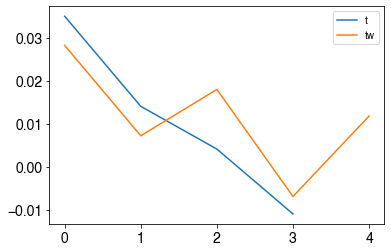

In [74]:
plt.plot(slopes_t, label='t')
plt.plot(slopes_tw, label='tw')
plt.legend()

In [168]:
mdl_wave_days_t_max.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     105.2
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           3.03e-24
Time:                        17:33:24   Log-Likelihood:                -2131.3
No. Observations:                2782   AIC:                             4267.
Df Residuals:                    2780   BIC:                             4278.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9775      0.014     68.788      0.000       0.950       1.005
x1            -0.0151      0.001    -10.255      0.000      -0.018      -0.012
==============================================================================
Omnibus:                      125.622   Durbin-Watson:                   0.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.468
Skew:                          -0.537   Prob(JB):                     5.19e-31
Kurtosis:                       2.778   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

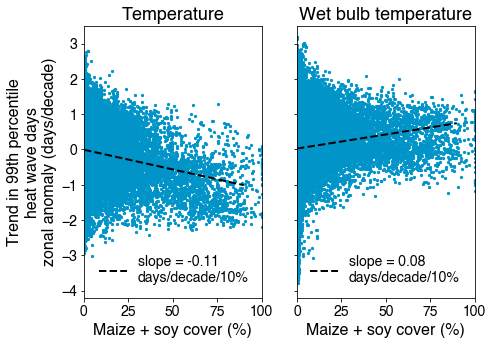

In [100]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7,5))

x1 = 0
x2 = 90

ax1.scatter(crop_ha_regrid_1d, trends_wave_days_t_max_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
ax1.plot([x1, x2], [mdl_wave_days_t_max.params[0], mdl_wave_days_t_max.params[0]+x2*mdl_wave_days_t_max.params[1]], '--k', lw=2, \
         label = 'slope = %.2f\ndays/decade/10%%'%(mdl_wave_days_t_max.params[1]*10))
ax1.set_title('Temperature', fontsize=18)
ax1.set_xlabel('Maize + soy cover (%)')
ax1.set_ylabel('Trend in 99th percentile\nheat wave days\nzonal anomaly (days/decade)')
ax1.set_xlim([0, 100])
ax1.set_ylim([-4.2, 3.5])
ax1.legend(prop={'size': 14}, frameon=False)

ax2.scatter(crop_ha_regrid_1d, trends_wave_days_tw_max_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
ax2.plot([x1, x2], [mdl_wave_days_tw_max.params[0], mdl_wave_days_tw_max.params[0]+x2*mdl_wave_days_tw_max.params[1]], '--k', lw=2, \
        label = 'slope = %.2f\ndays/decade/10%%'%(mdl_wave_days_tw_max.params[1]*10))
ax2.set_title('Wet bulb temperature', fontsize=18)
ax2.set_xlabel('Maize + soy cover (%)')
ax2.set_yticks(np.arange(-4, 3.1))
ax2.set_xlim([0, 100])
ax2.set_ylim([-4.2, 3.5])
ax2.legend(prop={'size': 14}, frameon=False)

# plt.savefig('figs/cropland-t-tw-zonal-mean-trends.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

# ax3.scatter(crop_ha_regrid_1d, trends_wave_days_t_min_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
# ax3.plot([x1, x2], [mdl_wave_days_t_min.params[0], mdl_wave_days_t_min.params[0]+x2*mdl_wave_days_t_min.params[1]], '--k', lw=2, \
#         label = 'slope = %.2f days/decade/10%%'%(mdl_wave_days_t_min.params[1]*10))
# ax3.set_title('T_min, q = %d'%q)
# ax3.set_xlabel('Crop cover (%)')
# ax3.set_ylabel('Cold wave days trend\nzonal anomaly\n(days/decade)')
# ax3.set_xlim([0, 100])
# # ax3.set_ylim([-4, 4])
# ax3.legend()

# ax4.scatter(crop_ha_regrid_1d, trends_wave_days_tw_min_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
# ax4.plot([x1, x2], [mdl_wave_days_tw_min.params[0], mdl_wave_days_tw_min.params[0]+x2*mdl_wave_days_tw_min.params[1]], '--k', lw=2, \
#         label = 'slope = %.2f days/decade/10%%'%(mdl_wave_days_tw_min.params[1]*10))
# ax4.set_title('TW_min, q = %d'%q)
# ax4.set_xlabel('Crop cover (%)')
# ax4.set_xlim([0, 100])
# # ax4.set_ylim([-4, 4])
# ax4.legend()


In [72]:
ind_no_crop = np.where((crop_ha_regrid_1d<=1))[0]
ind_low_crop = np.where((crop_ha_regrid_1d>1) & (crop_ha_regrid_1d<=25))[0]
ind_high_crop = np.where((crop_ha_regrid_1d>25))[0]

t_max_trend_no_crop = np.nanmedian(trends_wave_days_t_max_zonal_anom_1d[ind_no_crop, q])
t_max_trend_low_crop = np.nanmedian(trends_wave_days_t_max_zonal_anom_1d[ind_low_crop, q])
t_max_trend_high_crop = np.nanmedian(trends_wave_days_t_max_zonal_anom_1d[ind_high_crop, q])

tw_max_trend_no_crop = np.nanmedian(trends_wave_days_tw_max_zonal_anom_1d[ind_no_crop, q])
tw_max_trend_low_crop = np.nanmedian(trends_wave_days_tw_max_zonal_anom_1d[ind_low_crop, q])
tw_max_trend_high_crop = np.nanmedian(trends_wave_days_tw_max_zonal_anom_1d[ind_high_crop, q])


print(t_max_trend_no_crop, t_max_trend_low_crop, t_max_trend_high_crop)
print(tw_max_trend_no_crop, tw_max_trend_low_crop, tw_max_trend_high_crop)

0.8347558764880052 0.9666224785926698 0.7906920555326428
0.7798830927907219 0.9551428739071759 1.1489443741759706
